# Hotel Reservations Dataset

In [329]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay
from statsmodels.formula.api import logit
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import load_model, Sequential

warnings.simplefilter('ignore')

OUT = 'output'

Read in the raw data and get a feel for the data structures.

In [330]:
df = pd.read_csv('Hotel Reservations.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Filter to online reservations

In [331]:
df = df.loc[df.market_segment_type.eq('Online')]
print('Remaining Values:', df.shape[0])

Remaining Values: 23214


Check for duplicates and missing values

In [333]:
duplicates = df.duplicated().sum()
missing = df.isna().sum()
print('Duplicates:', duplicates, '\n')
print('Missing Values:')
print(missing)

Duplicates: 0 

Missing Values:
Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


Check for outliers

In [334]:
num_cols = [col for col in df.columns 
            if df[col].dtype != 'object' 
            and col not in ['required_car_parking_space', 'repeated_guest']]
df_zscore = df[num_cols].apply(zscore)
df_outliers = df_zscore.apply(lambda x: (x > 3) | (x < -3))
print('Outliers:')
df_outliers.sum()

Outliers:


no_of_adults                             149
no_of_children                          1051
no_of_weekend_nights                     155
no_of_week_nights                        279
lead_time                                280
arrival_year                               0
arrival_month                              0
arrival_date                               0
no_of_previous_cancellations              26
no_of_previous_bookings_not_canceled      32
avg_price_per_room                       450
no_of_special_requests                    71
dtype: int64

In [335]:
print('Outliers')
for col in df_outliers.columns:
    if df_outliers[col].sum() > 0:
        print(col, df[df_outliers[col]][col].sort_values().unique())

Outliers
no_of_adults [0 4]
no_of_children [ 2  3  9 10]
no_of_weekend_nights [4 5 6 7]
no_of_week_nights [ 7  8  9 10 11 12 13 14 15 16 17]
lead_time [298 299 300 301 302 303 304 305 306 307 308 309 310 311 313 314 315 317
 319 320 322 323 324 325 326 327 328 330 331 332 333 335 338 341 345 346
 349 350 351 352 353 355 359 361 372 377 381 386 418 433 443]
no_of_previous_cancellations [ 3 11]
no_of_previous_bookings_not_canceled [ 2  3  4  5  6 10 16 19 20 21 22]
avg_price_per_room [  0.     0.5    1.     1.48   2.     3.     6.   218.   218.03 218.72
 218.96 219.   219.6  220.   220.53 220.73 221.   221.18 221.3  221.33
 221.38 221.39 221.4  222.17 223.   223.75 223.76 224.   224.1  224.33
 224.5  224.67 225.   225.2  225.36 225.4  226.17 226.35 226.5  227.15
 227.9  228.   228.33 228.6  228.8  229.   229.46 229.6  230.   231.
 231.15 231.5  231.6  231.78 232.33 232.5  233.1  233.33 234.   234.35
 234.71 235.33 235.5  235.63 235.94 236.14 236.52 237.   237.2  237.6
 237.75 238.15 239.

Drop outliers

outliers violate the assumptions made during Logistic Regression

In [336]:
df = df[~df_outliers.no_of_adults & 
        ~df_outliers.no_of_children & 
        ~df_outliers.no_of_weekend_nights &
        ~df_outliers.no_of_week_nights & 
        ~df_outliers.lead_time & 
        ~df_outliers.no_of_previous_cancellations &
        ~df_outliers.no_of_previous_bookings_not_canceled & 
        ~df_outliers.avg_price_per_room &
        ~df_outliers.no_of_special_requests]

print('Remaining rows:', df.shape[0])

Remaining rows: 21221


## Deterministic Matching

Identify canceled bookings that were rescheduled at a lower rate

Matching Rules:
1. First booking must be cancelled (`booking_status == 'Canceled'`)
2. Second booking must not be cancelled (`booking_status == 'Not_Canceled'`)
3. Date, Room Type, Meal Plan, Parking, Adults/Children, Weekends/Weekdays, Special Requests
4. Second booking rate must be lower than first booking rate (`avg_price_per_room_1 > avg_price_per_room_2`)
5. First booking lead time must be longer than the second booking rate (`lead_time_1 > lead_time_2`)


In [337]:
# Identify potential canceled and rebooked reservations
first_booking = df[df.booking_status.eq('Canceled')]
second_booking = df[df.booking_status.eq('Not_Canceled')]

# Match records on designated fields
groupers = ['arrival_year', 'arrival_month', 'arrival_date', 'room_type_reserved',
            'type_of_meal_plan', 'required_car_parking_space', 'no_of_adults', 
            'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights']
rebooks = first_booking.merge(second_booking, on=groupers, suffixes=['_1', '_2'])

# Filter to last two rules (avg price per day & lead time)
rebooks = rebooks[rebooks.Booking_ID_1.ne(rebooks.Booking_ID_2) & 
                  rebooks.avg_price_per_room_1.gt(rebooks.avg_price_per_room_2) &
                  rebooks.lead_time_1.gt(rebooks.lead_time_2)]
rebooks

,Booking_ID_1,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time_1,arrival_year,...,booking_status_1,Booking_ID_2,lead_time_2,market_segment_type_2,repeated_guest_2,no_of_previous_cancellations_2,no_of_previous_bookings_not_canceled_2,avg_price_per_room_2,no_of_special_requests_2,booking_status_2
10,INN00040,2,0,2,1,Meal Plan 1,0,Room_Type 4,186,2018,...,Canceled,INN00576,20,Online,0,0,0,117.55,1,Not_Canceled
140,INN00172,2,0,1,2,Not Selected,0,Room_Type 1,185,2018,...,Canceled,INN07101,9,Online,0,0,0,78.00,0,Not_Canceled
141,INN00172,2,0,1,2,Not Selected,0,Room_Type 1,185,2018,...,Canceled,INN08989,9,Online,0,0,0,78.00,0,Not_Canceled
142,INN00172,2,0,1,2,Not Selected,0,Room_Type 1,185,2018,...,Canceled,INN11725,9,Online,0,0,0,78.00,0,Not_Canceled
145,INN00172,2,0,1,2,Not Selected,0,Room_Type 1,185,2018,...,Canceled,INN23454,9,Online,0,0,0,78.00,0,Not_Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,INN36155,2,0,1,1,Meal Plan 1,0,Room_Type 1,110,2018,...,Canceled,INN35210,13,Online,0,0,0,85.47,1,Not_Canceled
11160,INN36216,2,0,0,2,Meal Plan 1,0,Room_Type 1,44,2017,...,Canceled,INN14820,14,Online,0,0,0,97.02,2,Not_Canceled
11161,INN36239,1,0,0,1,Not Selected,0,Room_Type 1,117,2018,...,Canceled,INN17248,21,Online,0,0,0,123.20,1,Not_Canceled
11162,INN36239,1,0,0,1,Not Selected,0,Room_Type 1,117,2018,...,Canceled,INN29010,21,Online,0,0,0,123.20,1,Not_Canceled


Label the cancellations that were rebooked

In [338]:
data = df

# Label the canceled reservation as rebooked and everything else as not rebooked
data['rebook'] = np.where(data.Booking_ID.isin(rebooks.Booking_ID_1), 1, 0)

# Drop Booking_ID; no longer needed
data.drop(['Booking_ID'], axis=1, inplace=True)

print('rebook value counts:')
data.rebook.value_counts()

rebook value counts:


0    20223
1      998
Name: rebook, dtype: int64

## Univariate Analysis

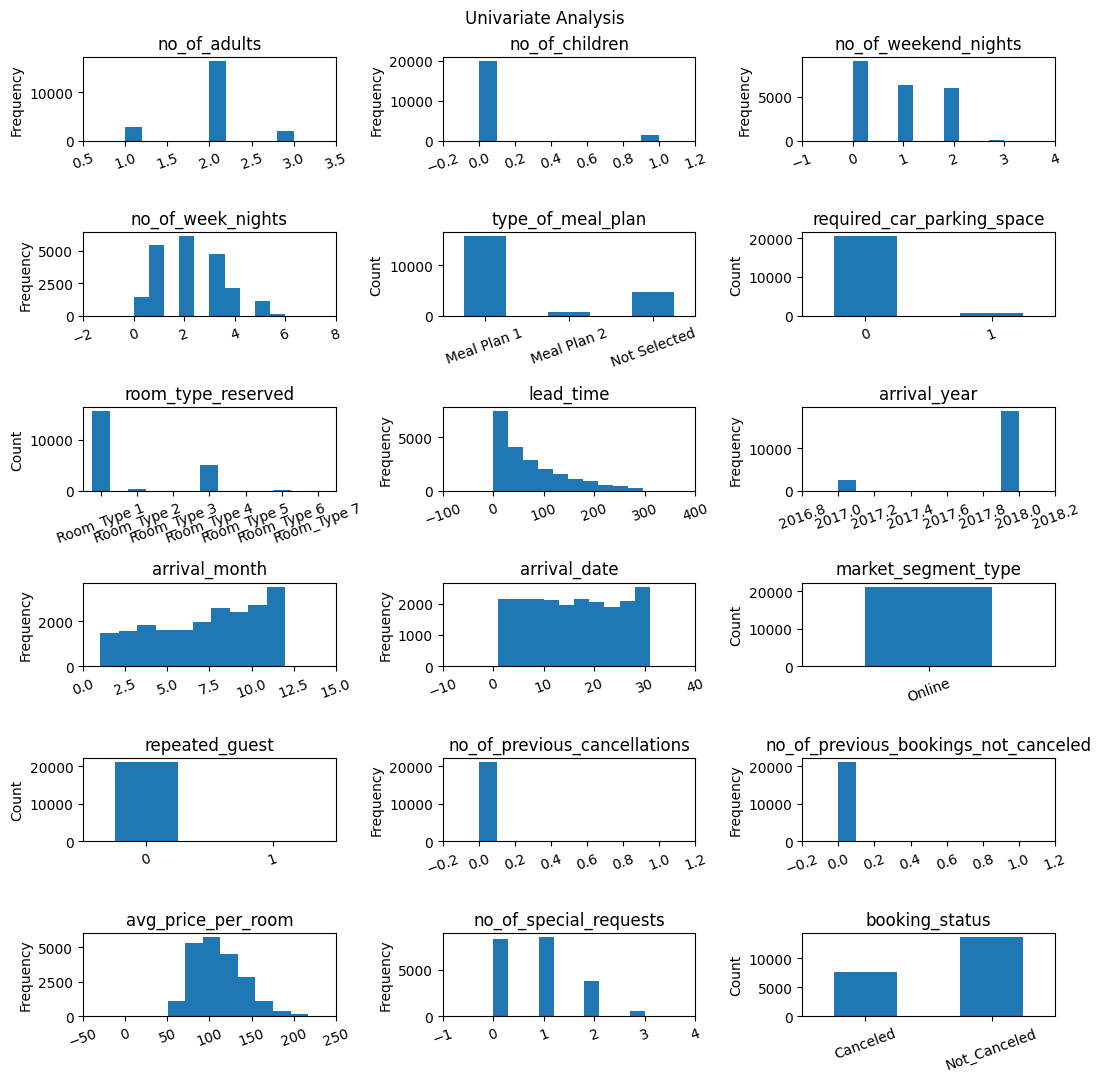

In [349]:
cols = np.reshape([col for col in df.columns if col != 'rebook'], (6, 3))
fig, ax = plt.subplots(6, 3, figsize=(11, 11))
fig.suptitle('Univariate Analysis')
for r, row in enumerate(cols):
    for c, col in enumerate(row):
        if col not in num_cols:
            grp = df[col].value_counts().sort_index()
            grp.plot(kind='bar', ax=ax[r, c], ylabel='Count', rot=20)
        else:
            df[col].plot(kind='hist', ax=ax[r, c], rot=20)
        ax[r, c].set_xticks(ax[r, c].get_xticks(), 
                            ha='right', rotation_mode='anchor')
        ax[r, c].set_title(col)
plt.tight_layout()
plt.show()

Drop arrival year and arrival date. Arrival year will not extrapolate well to the future. Arrival date is nearly uniform so it will not add value.

In [317]:
data.drop(['arrival_year', 'arrival_date', 'market_segment_type'], axis=1, inplace=True)
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,rebook
1,2,0,2,3,Not Selected,0,Room_Type 1,5,11,0,0,0,106.68,1,Not_Canceled,0
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2,0,0,0,60.00,0,Canceled,0
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,5,0,0,0,100.00,0,Canceled,0
4,2,0,1,1,Not Selected,0,Room_Type 1,48,4,0,0,0,94.50,0,Canceled,0
6,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,10,0,0,0,107.55,1,Not_Canceled,0


## Bivariate Analysis

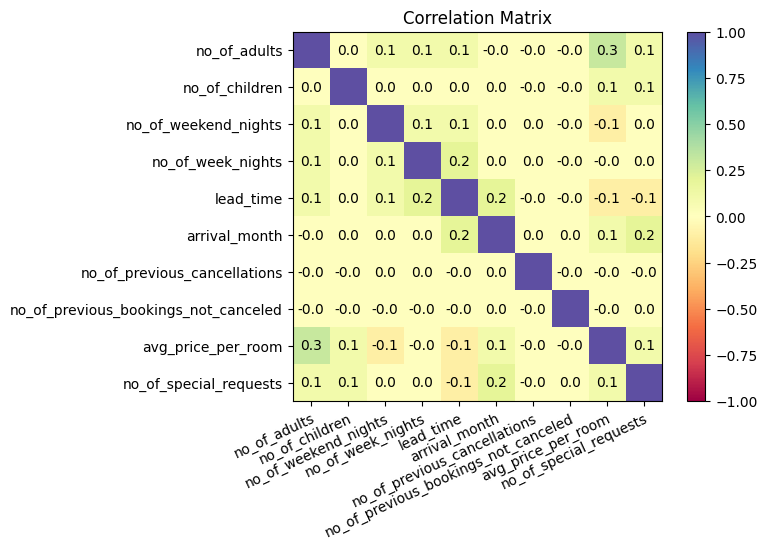

<Figure size 800x800 with 0 Axes>

In [318]:
num_cols = [col for col in data.columns 
            if data[col].dtype != 'object' 
            and col not in ['required_car_parking_space', 'repeated_guest', 'rebook']]
cm = data[num_cols].corr().round(1)
im = plt.imshow(cm, cmap='Spectral', vmin=-1, vmax=1)
for r, row in enumerate(cm.index):
    for c, col in enumerate(cm.columns):
        if cm.loc[row, col] != 1.0:
            text = plt.text(r, c, cm.loc[row, col], ha='center', va='center')
plt.xticks(range(len(cm.index)), cm.index, rotation=25, rotation_mode='anchor', ha='right')
plt.yticks(range(len(cm.columns)), cm.columns)
plt.colorbar()
plt.title('Correlation Matrix')
plt.figure(figsize=(8, 8))
plt.tight_layout()

Compare each variable against the target, rebook

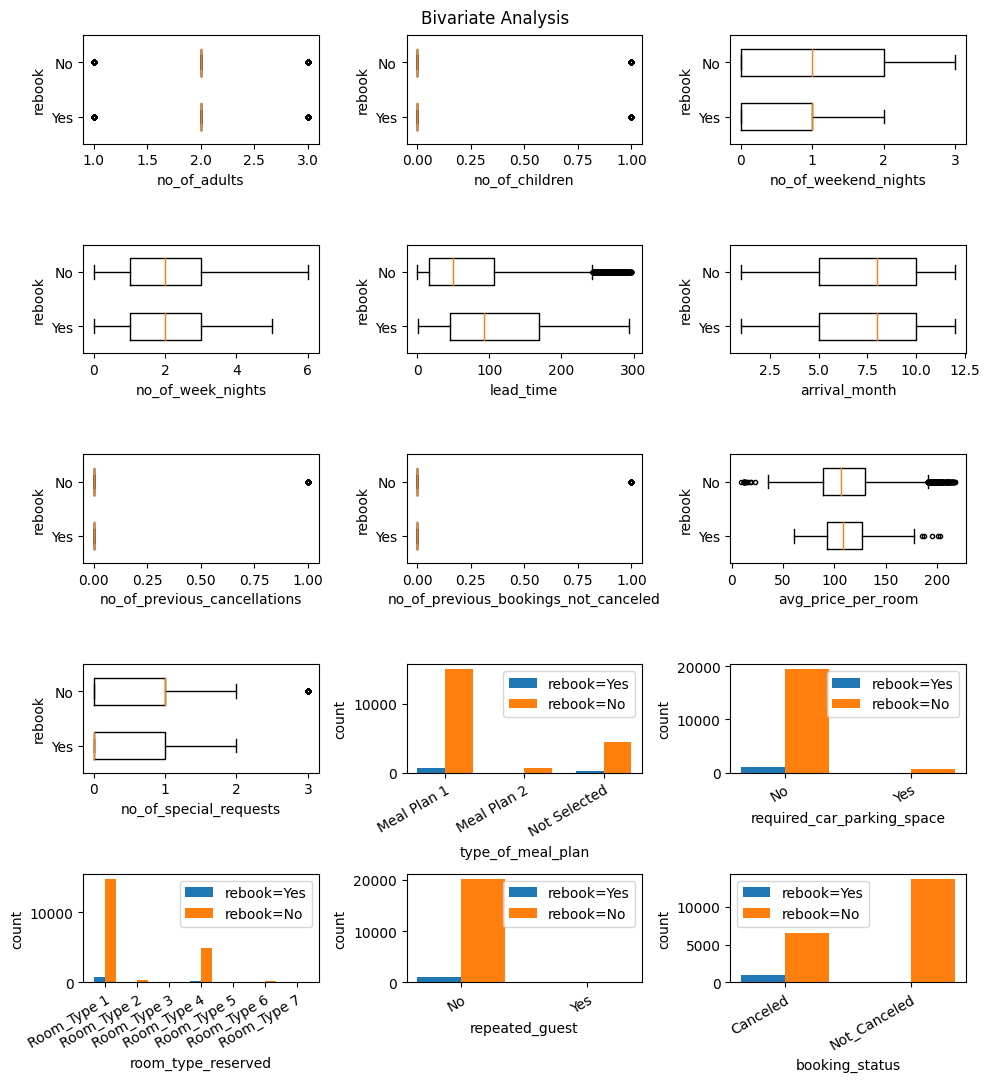

In [319]:
cat_cols = [col for col in data.columns if col not in num_cols and col != 'rebook']
cols = np.reshape(num_cols + cat_cols, (5, 3))
fig, ax = plt.subplots(5, 3, figsize=(10, 11))
fig.suptitle('Bivariate Analysis')
for r, row in enumerate(cols):
    for c, col in enumerate(row):
        if col in cat_cols:
            groups = data[col].sort_values().unique()
            rebook_yes = data.loc[data.rebook.eq(1), 
                                  ['rebook', col]].groupby(col).count()['rebook']
            rebook_no = data.loc[data.rebook.eq(0), 
                                 ['rebook', col]].groupby(col).count()['rebook']
            for group in groups:
                if group not in rebook_yes.index:
                    rebook_yes = rebook_yes.append(pd.Series({group: 0}))
                if group not in rebook_no.index:
                    rebook_no = rebook_no.append(pd.Series({group: 0}))
            labels = data[col].replace({1:'Yes', 0:'No'}).sort_values().unique()
            x = np.arange(len(labels))
            width = 0.35
            bar1 = ax[r, c].bar(x-width/2, rebook_yes.sort_index(), width, label='rebook=Yes')
            bar2 = ax[r, c].bar(x+width/2, rebook_no.sort_index(), width, label='rebook=No')
            ax[r, c].set_xticks(x, labels)
            ax[r, c].set_ylabel('count')
            plt.setp(ax[r, c].get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
            ax[r, c].legend()
        else:
            rebook_yes = data.loc[data.rebook.eq(1), col].values
            rebook_no = data.loc[data.rebook.eq(0), col].values
            ax[r, c].boxplot([rebook_yes, rebook_no], labels=['Yes', 'No'], 
                             vert=False, widths=0.5, sym='.')
            ax[r, c].set_ylabel('rebook')
        ax[r, c].set_xlabel(col)
fig.set_tight_layout(True)
plt.show()

Scale numeric variables

In [320]:
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled.loc[:, num_cols] = scaler.fit_transform(data_scaled.loc[:, num_cols])
data_scaled[num_cols]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_month,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
1,0.093505,-0.261268,1.367996,0.605486,-0.990040,1.198319,-0.031473,-0.033649,-0.127818,0.198963
2,-2.017415,-0.261268,1.367996,-0.931385,-1.048609,-1.751628,-0.031473,-0.033649,-1.739244,-1.039215
3,0.093505,-0.261268,-1.034374,-0.162950,2.026259,-0.768312,-0.031473,-0.033649,-0.358416,-1.039215
4,0.093505,-0.261268,0.166811,-0.931385,-0.360424,-1.096084,-0.031473,-0.033649,-0.548280,-1.039215
6,0.093505,-0.261268,0.166811,0.605486,-0.565415,0.870547,-0.031473,-0.033649,-0.097785,0.198963
...,...,...,...,...,...,...,...,...,...,...
36267,0.093505,-0.261268,0.166811,-1.699821,-0.345782,-0.112769,-0.031473,-0.033649,-0.594883,-1.039215
36270,2.204424,-0.261268,1.367996,2.910792,0.181338,0.215003,-0.031473,-0.033649,1.982087,0.198963
36271,0.093505,-0.261268,0.166811,0.605486,2.275177,0.870547,-0.031473,-0.033649,-0.670828,1.437140
36272,0.093505,-0.261268,1.367996,2.910792,1.103799,-0.112769,-0.031473,-0.033649,-0.413994,1.437140


One-hot encode categorical variables.

In [323]:
data_encoded = pd.get_dummies(data_scaled, 
                              columns=cat_cols).drop(['type_of_meal_plan_Not Selected',
                                                      'required_car_parking_space_0',
                                                      'room_type_reserved_Room_Type 7',
                                                      'repeated_guest_0',
                                                      'booking_status_Not_Canceled'], axis=1)
data_encoded.columns = [col.replace(' ', '_') for col in data_encoded.columns]
data_encoded[[col for col in data_encoded.columns if col not in num_cols]]

,rebook,type_of_meal_plan_Meal_Plan_1,type_of_meal_plan_Meal_Plan_2,required_car_parking_space_1,room_type_reserved_Room_Type_1,room_type_reserved_Room_Type_2,room_type_reserved_Room_Type_3,room_type_reserved_Room_Type_4,room_type_reserved_Room_Type_5,room_type_reserved_Room_Type_6,repeated_guest_1,booking_status_Canceled
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,1
6,0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36267,1,0,0,0,1,0,0,0,0,0,0,1
36270,0,1,0,0,0,0,0,1,0,0,0,0
36271,1,1,0,0,1,0,0,0,0,0,0,1
36272,0,1,0,0,1,0,0,0,0,0,0,0


Check for multicollinearity

In [324]:
X = data_encoded.loc[:, [col for col in data_encoded.columns if col != 'rebook']]
vif_data = pd.DataFrame().from_dict({'feature': X.columns,
                                     'vif': [variance_inflation_factor(X.values, i) 
                                             for i in range(X.shape[1])]})
vif_data

,feature,vif
0,no_of_adults,1.251415
1,no_of_children,1.075653
2,no_of_weekend_nights,1.030331
3,no_of_week_nights,1.100853
4,lead_time,1.449710
5,arrival_month,1.108486
6,no_of_previous_cancellations,145023.775926
7,no_of_previous_bookings_not_canceled,165720.925362
8,avg_price_per_room,1.670488
9,no_of_special_requests,1.302534


repeated_guest_1 appears to have high correlation with several other variables. 
After removing repeated_guest_1, type_of_meal_plan_Meal_Plan_1 still had a VIF over 5.

In [325]:
X.drop(['repeated_guest_1', 'type_of_meal_plan_Meal_Plan_1'], axis=1, inplace=True)
vif_data = pd.DataFrame().from_dict({'feature': X.columns,
                                     'vif': [variance_inflation_factor(X.values, i) 
                                             for i in range(X.shape[1])]})
vif_data

,feature,vif
0,no_of_adults,1.239871
1,no_of_children,1.066903
2,no_of_weekend_nights,1.025194
3,no_of_week_nights,1.089403
4,lead_time,1.424460
5,arrival_month,1.103314
6,no_of_previous_cancellations,1.004274
7,no_of_previous_bookings_not_canceled,1.002255
8,avg_price_per_room,1.596995
9,no_of_special_requests,1.300189


Split the data into training, validation, and testing data. Training data will be used to fit the model, validation data will be used to prevent overfitting the model, and testing data will be used to obtaint he final accuracy score of the model.

In [326]:
y = data_encoded.loc[:, 'rebook']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=8, stratify=y)

pd.DataFrame(X_train, columns=X.columns).to_csv(os.path.join(OUT, 'X_train.csv'), index=False)
pd.DataFrame(y_train, columns=[y.name]).to_csv(os.path.join(OUT, 'y_train.csv'), index=False)
pd.DataFrame(X_test, columns=X.columns).to_csv(os.path.join(OUT, 'X_test.csv'), index=False)
pd.DataFrame(y_test, columns=[y.name]).to_csv(os.path.join(OUT, 'y_test.csv'), index=False)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (16976, 19)
y_train shape: (16976,)
X_test shape: (4245, 19)
y_test shape: (4245,)


## Verifying Assumptions

### Model Assumption 1: binary response variable

In [264]:
train = pd.concat([y_train, X_train], axis=1)
print(f'rebook unique values: {train.rebook.nunique()}')

rebook unique values: 2


### Model Assumption 2: independent observations

This assumption is possibly violated by repeat hotel guests. Could potentially handle by excluding repeat customers...

### Model Assumption 3: no multicollinearity

In [265]:
vif_data = pd.DataFrame().from_dict({'feature': X.columns, 
                                     'vif': [variance_inflation_factor(X.values, i) 
                                             for i in range(X.shape[1])]})
vif_data

,feature,vif
0,no_of_adults,1.239871
1,no_of_children,1.066903
2,no_of_weekend_nights,1.025194
3,no_of_week_nights,1.089403
4,lead_time,1.424460
5,arrival_month,1.103314
6,no_of_previous_cancellations,1.004274
7,no_of_previous_bookings_not_canceled,1.002255
8,avg_price_per_room,1.596995
9,no_of_special_requests,1.300189


### Model Assumption 4: no outliers

All outliers were excluded during the data cleaning phase

### Model Assumption 5: linearity

Box-Tidwell test

In [266]:
test_data = train.loc[:, ['rebook', 'no_of_children', 'no_of_week_nights', 'lead_time', 
                          'avg_price_per_room', 'no_of_special_requests']]
for col in test_data.columns[1:]:
    test_data[f'{col}_x_Log_{col}'] = test_data[col] * np.log1p(test_data[col])
test_data = add_constant(test_data, prepend=False).dropna()
bt_results = GLM(test_data.rebook, test_data.iloc[:, 1:], family=Binomial()).fit()
print(bt_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rebook   No. Observations:                 7252
Model:                            GLM   Df Residuals:                     7242
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -902.62
Date:                Mon, 30 Jan 2023   Deviance:                       1805.2
Time:                        20:49:33   Pearson chi2:                 6.60e+03
No. Iterations:                   100   Pseudo R-squ. (CS):            0.02076
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

All x_log p-values are greater than 0.05. This means there is not a statistically significant logistic relationship between rebook and the interaction of any numeric variables with their log values. This confirms the linear relationship between rebook and each of the numeric variables.

### Model Assumption 6: sufficient sample size

In [267]:
min_sample = 10
n_vars = X.shape[1]
min_prob = train[train.rebook.eq(1)].shape[0] / train.shape[0]
print(f'Minimum samples per group: {min_sample}, Variables: {n_vars}, Min Probability: {min_prob}')
print(f'Minimum Sample Size: {int(np.ceil((min_sample * n_vars) / min_prob))}')
print(f'Actual sample size: {train.shape[0]}')

Minimum samples per group: 10, Variables: 19, Min Probability: 0.047007540056550425
Minimum Sample Size: 4042
Actual sample size: 16976


## Gross Logistic Regression Model

Dropping no_of_week_nights because there is no linearity between it and the logit of rebook.

In [350]:
train.drop('no_of_week_nights', axis=1, inplace=True)

Refereced [this article](https://machinelearningmastery.com/bfgs-optimization-in-python/) to decide which optimization function to use. Excellent article!!

In [364]:
formula = f'rebook ~ {" + ".join([x for x in train.columns[1:]])}'
model1 = logit(formula, train).fit(method='bfgs', maxiter=150)
print(model1.summary())

         Current function value: 0.131508
         Iterations: 150
         Function evaluations: 151
         Gradient evaluations: 151
                           Logit Regression Results                           
Dep. Variable:                 rebook   No. Observations:                16976
Model:                          Logit   Df Residuals:                    16957
Method:                           MLE   Df Model:                           18
Date:                Wed, 01 Feb 2023   Pseudo R-squ.:                  0.3064
Time:                        22:22:08   Log-Likelihood:                -2232.5
converged:                      False   LL-Null:                       -3218.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept            

## Feature Selection
Backwards stepwise feature selection

In [27]:
def reduce_model(model: logit, data: pd.DataFrame) -> logit:
    features = model.params.index.to_list()
    features.pop(0)
    highest_p = model.pvalues.argmax() - 1
    print(f'Removing {features[highest_p]} with a p-value of {float(model.pvalues[highest_p + 1])}')
    features.pop(highest_p)
    formula = f'rebook ~ {" + ".join(features)}'
    model = logit(formula=formula, data=data).fit(method='bfgs', maxiter=150)
    return model

In [376]:
model2 = model1
while model2.pvalues.max() >= 0.05:
    model2 = reduce_model(model2, train)

Removing no_of_previous_bookings_not_canceled with a p-value of 0.9999998915952081
Optimization terminated successfully.
         Current function value: 0.131508
         Iterations: 149
         Function evaluations: 150
         Gradient evaluations: 150
Removing no_of_previous_cancellations with a p-value of 0.99906159479156
         Current function value: 0.131514
         Iterations: 150
         Function evaluations: 151
         Gradient evaluations: 151
Removing booking_status_Canceled with a p-value of 0.9962966104148651
Optimization terminated successfully.
         Current function value: 0.166996
         Iterations: 122
         Function evaluations: 123
         Gradient evaluations: 123
Removing room_type_reserved_Room_Type_3 with a p-value of 0.8878185650097263
Optimization terminated successfully.
         Current function value: 0.166999
         Iterations: 122
         Function evaluations: 123
         Gradient evaluations: 123
Removing no_of_adults with a p-valu

## Final Model

In [377]:
print(model2.summary())

                           Logit Regression Results                           
Dep. Variable:                 rebook   No. Observations:                16976
Model:                          Logit   Df Residuals:                    16968
Method:                           MLE   Df Model:                            7
Date:                Wed, 01 Feb 2023   Pseudo R-squ.:                  0.1108
Time:                        22:26:40   Log-Likelihood:                -2862.3
converged:                       True   LL-Null:                       -3218.8
Covariance Type:            nonrobust   LLR p-value:                1.099e-149
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -5.6292      0.511    -11.022      0.000      -6.630      -4.628
no_of_children                    -0.3241      0.062     -5.247      0.

## Model Metrics

Accuracy: 0.9529335532516494
Recall: 0.0


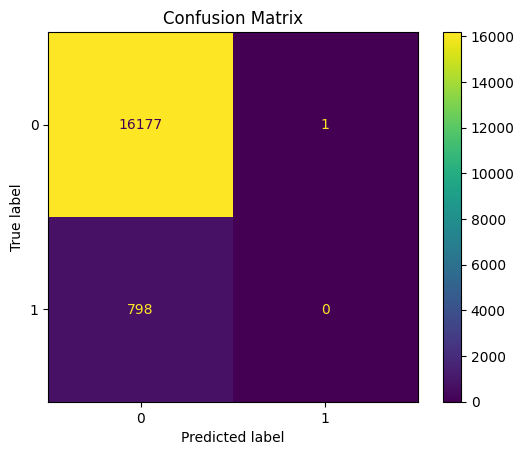

In [380]:
train_pred = np.round(model2.predict(X_train))
train_cm = confusion_matrix(y_train, train_pred)

_, ax = plt.subplots()
train_disp = ConfusionMatrixDisplay(train_cm)
train_disp.plot(ax=ax)
ax.set_title('Confusion Matrix')
print('Accuracy:', accuracy_score(y_train, train_pred))
print('Recall:', recall_score(y_train, train_pred))

After reducing the model, it is still not able to predict when a reservation will be rebooked. Next, a Neural Network will be utilized to see if it can better capture the patterns in the data. Only the statistically significantly predictive features from the reduced model will be used as the independent features.

To properly fit a neural network, a validation dataset is needed in addition to the test and train datasets. To handle this the data will be re-split into 60% training, 20% validation, and 20% testing data.

In [381]:
final_data = data_encoded.loc[:, model2.params.index.to_list()[1:] + ['rebook']]

X = final_data.loc[:, final_data.columns != ('rebook')]
y = final_data.loc[:, 'rebook']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, 
                                                random_state=42)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

pd.DataFrame(X_train).to_csv(os.path.join(OUT, 'X_train.csv'), index=False)
pd.DataFrame(y_train).to_csv(os.path.join(OUT, 'y_train.csv'), index=False)
pd.DataFrame(X_val).to_csv(os.path.join(OUT, 'X_val.csv'), index=False)
pd.DataFrame(y_val).to_csv(os.path.join(OUT, 'y_val.csv'), index=False)
pd.DataFrame(X_test).to_csv(os.path.join(OUT, 'X_test.csv'), index=False)
pd.DataFrame(y_test).to_csv(os.path.join(OUT, 'y_test.csv'), index=False)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (12732, 7)
y_train shape: (12732,)
X_val shape: (4244, 7)
y_val shape: (4244,)
X_test shape: (4245, 7)
y_test shape: (4245,)


Initial Neural Network

In [382]:
model3 = Sequential(name='Model3')
model3.add(InputLayer(input_shape=(X.shape[1],), name='Input'))
model3.add(Dense(500, activation='relu', name='Dense_500_reLU'))
model3.add(Dense(250, activation='relu', name='Dense_250_reLU'))
model3.add(Dense(1, activation='sigmoid', name='Output'))
model3.compile(loss=BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.94), 
               optimizer='adam', metrics=[Recall(name='recall'), 'accuracy'])
model3.summary()

Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_500_reLU (Dense)      (None, 500)               4000      
                                                                 
 Dense_250_reLU (Dense)      (None, 250)               125250    
                                                                 
 Output (Dense)              (None, 1)                 251       
                                                                 
Total params: 129,501
Trainable params: 129,501
Non-trainable params: 0
_________________________________________________________________


Fit the Neural Network

In [384]:
monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history3 = model3.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], 
                      callbacks=[monitor])

Epoch 1/50
398/398 [==============================] - 8s 21ms/step - loss: 0.0148 - recall: 0.7045 - accuracy: 0.6990 - val_loss: 0.0145 - val_recall: 0.7739 - val_accuracy: 0.6451
Epoch 2/50
398/398 [==============================] - 8s 21ms/step - loss: 0.0143 - recall: 0.7195 - accuracy: 0.6986 - val_loss: 0.0144 - val_recall: 0.7286 - val_accuracy: 0.6918
Epoch 3/50
398/398 [==============================] - 9s 22ms/step - loss: 0.0143 - recall: 0.7195 - accuracy: 0.7078 - val_loss: 0.0145 - val_recall: 0.7085 - val_accuracy: 0.7156
Epoch 4/50
398/398 [==============================] - 9s 22ms/step - loss: 0.0142 - recall: 0.7078 - accuracy: 0.7134 - val_loss: 0.0143 - val_recall: 0.7839 - val_accuracy: 0.6466
Epoch 5/50
398/398 [==============================] - 9s 22ms/step - loss: 0.0140 - recall: 0.7346 - accuracy: 0.7056 - val_loss: 0.0149 - val_recall: 0.6884 - val_accuracy: 0.6927
Epoch 6/50
398/398 [==============================] - 9s 22ms/step - loss: 0.0141 - recall: 0.7

In [394]:
def plot_learning_curve(hx_obj, epochs: int) -> None:
    epoch_range = range(1, epochs + 1)
    _, (ax1, ax2) = plt.subplots(2, figsize=(6, 8), sharex=True)
    ax1.plot(epoch_range, hx_obj.history['recall'], label='Train')
    ax1.plot(epoch_range, hx_obj.history['val_recall'], label='Val')
    ax1.set_title('Model Recall')
    ax1.set_ylabel('Recall')
    ax1.legend()
    ax2.plot(epoch_range, hx_obj.history['loss'], label='Train', scaley='log')
    ax2.plot(epoch_range, hx_obj.history['val_loss'], label='Val', scaley='log')
    ax2.set_yscale('log')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss (log scale)')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.tight_layout()
    plt.show()

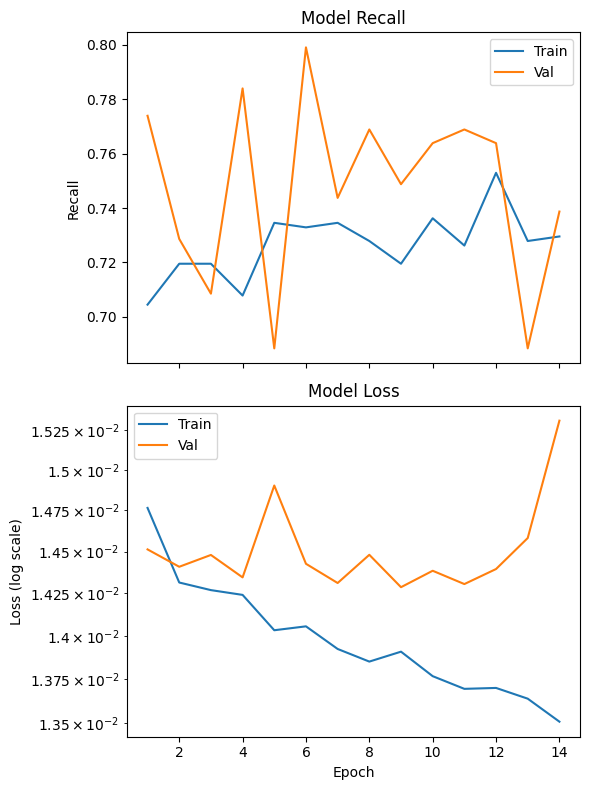

In [395]:
plot_learning_curve(history3, len(history3.history['recall']))

In [386]:
train_pred3 = np.round(model3.predict(X_train))
print('Recall:', recall_score(y_train, train_pred3))
print('Accuracy:', accuracy_score(y_train, train_pred3))

398/398 [==============================] - 4s 10ms/step
Recall: 0.7662771285475793
Accuracy: 0.7105717876217404


In [387]:
val_pred3 = np.round(model3.predict(X_val))
print('Recall:', recall_score(y_val, val_pred3))
print('Accuracy:', accuracy_score(y_val, val_pred3))

133/133 [==============================] - 2s 11ms/step
Recall: 0.7487437185929648
Accuracy: 0.693449575871819


In [388]:
model3.save(os.path.join(OUT, 'hotel_rebook_model.h5'))

133/133 [==============================] - 3s 13ms/step
Recall: 0.73
Accuracy: 0.7090694935217904


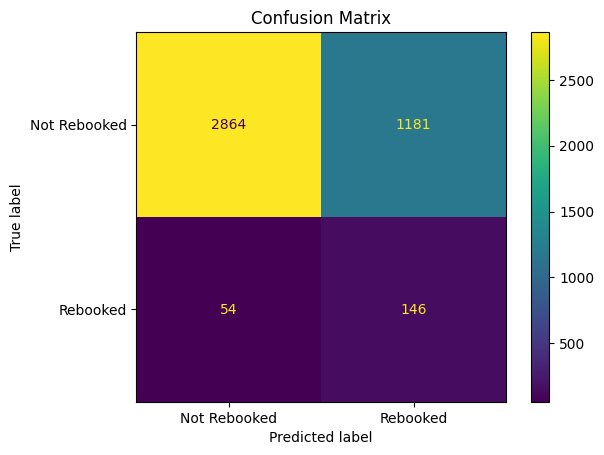

In [391]:
X_test = pd.read_csv(os.path.join(OUT, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(OUT, 'y_test.csv'))
model = load_model(os.path.join(OUT, 'hotel_rebook_model.h5'))
predictions = np.round(model.predict(X_test))
cm = confusion_matrix(y_test, predictions)

_, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Rebooked', 'Rebooked'])
disp.plot(ax=ax)
ax.set_title('Confusion Matrix')
print('Recall:', recall_score(y_test, predictions))
print('Accuracy:', accuracy_score(y_test, predictions))